In [1]:
import matplotlib.pyplot as plt
import numpy  as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.gridspec   as gridspec
from matplotlib              import dates as mdates
from datetime                import datetime, timedelta
import scipy.io
from scipy.interpolate import griddata
import cartopy.crs           as ccrs
import cartopy.feature       as cfeature
import gsw

## Load the data

### GLIDERS

In [2]:
# dir_gliders = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/dynamic_height/gliders/'
dir_gliders = '/home/everger/ONEDRIVE/SWOT/dynamic_height/gliders/'

MAT FILE FROM NIKOS AND BÀRBARA THAT ALREADY CONTAINS DH COMPUTATION

In [3]:
mat = scipy.io.loadmat(dir_gliders+'DH_Elisabet.mat') # té els resultats per diferents profs

In [4]:
glider_num = '09'

Extract variables:

In [5]:
glider_type = 'raw' # raw or 'filtered'

if glider_type == 'raw':
    type = 'bindata'+glider_num # 'sp09' (filtered) or 'bindata09' (raw)
elif glider_type == 'filtered':
    type = 'sp'+glider_num 

In [6]:
# glider 09
lon = mat[type]['lon_dh']; lon = lon[0,0][0]
lat = mat[type]['lat_dh']; lat = lat[0,0][0]

time = mat[type]['time_dh']
time = time[0,0][0]
time = [datetime.fromordinal(int(d)) + timedelta(days=d%1) - timedelta(days=366) for d in time]

p = mat[type]['pr_dh']

dh_an_700 = mat[type]['dyn_height_anom_dh_700'] # dh anomaly with ref level 700m ANOMALIA!!
dh_an_90 = mat[type]['dyn_height_anom_dh_90'] # dh with ref level 90m

dh_700 = mat[type]['dyn_height_dh_700'] # NO ANOMALIA!!
dh_90 = mat[type]['dyn_height_dh_90'] 


**Select dh value at 10 m of each array**

In [7]:
dh_all_700 = []
    
for i in range(len(dh_700[0,0].T)): 
    
    DH_700 = dh_700[0,0].T[i][5] # valor a 10m
    dh_all_700.append(DH_700)

In [8]:
dh_all_700 = np.array(dh_all_700)

SELECT SECTION :

In [9]:
section = 4

In [10]:
''' Glider SDEEP09 - Section 2:  {'28-Apr-2023 09:48:45'} -  {'01-May-2023 15:42:41’} - profiles 67 to 144 '''
''' Glider SDEEP09 - Section 4:  {'03-May-2023 15:39:33'} -  {'07-May-2023 07:38:00}'''

''' Glider SDEEP01 - Section 2:  {'28-Apr-2023 08:59:10’} -  {'02-May-2023 15:04:27’} - profiles 60 to 152 '''
''' Glider SDEEP01 - Section 4:  {'04-May-2023 15:40:55'} -  {'07-May-2023 23:40:31}'''

if glider_num == '09':
    if section == 2: 
        start_datetime = np.datetime64(datetime(2023, 4, 28, 9, 48))
        end_datetime = np.datetime64(datetime(2023, 5,1,15,42))
    elif section == 4: 
        start_datetime = np.datetime64(datetime(2023, 5, 3, 15, 39))
        end_datetime = np.datetime64(datetime(2023, 5, 7, 7, 38))

elif glider_num == '01':
    if section == 2: 
        start_datetime = np.datetime64(datetime(2023, 4, 28, 8, 59))
        end_datetime = np.datetime64(datetime(2023, 5, 2, 15, 4))
    elif section == 4: 
        start_datetime = np.datetime64(datetime(2023, 5, 4, 15, 40))
        end_datetime = np.datetime64(datetime(2023, 5, 7, 23, 40))
        

time = np.array(time)
t = time[(time < end_datetime) & (time > start_datetime)]

dh_700 = dh_all_700[(time < end_datetime) & (time > start_datetime)]

Lon = lon[(time < end_datetime) & (time > start_datetime)]
Lat = lat[(time < end_datetime) & (time > start_datetime)]

In [11]:
# compute diff t in hours
diff_t = np.diff(t)
diff_t = np.array([d.total_seconds() for d in diff_t])
diff_t = diff_t/3600
diff_t

array([1.49400014, 1.64249988, 1.71248475, 1.79166325, 1.09848045,
       0.360881  , 1.14405063, 1.79131772, 1.82040508, 1.82225061,
       1.08409929, 0.35043799, 1.11407759, 1.7612267 , 1.80412539,
       1.80835399, 1.1108112 , 0.38319085, 1.55641224, 1.60555425,
       1.58736778, 1.58241435, 1.05618922, 0.52285414, 1.23104133,
       1.60126573, 1.62581302, 1.64490649, 1.14640869, 0.67142512,
       1.30329001, 1.60848539, 1.64273718, 1.66073722, 1.14254956,
       0.63641984, 1.28469495, 1.64348814, 1.66510085, 1.68477057,
       1.14273435, 0.6085038 , 1.30134152, 1.65279843, 1.6703844 ,
       1.68061655, 1.13098744, 0.60452957, 1.28850529, 1.63690067,
       1.67548864, 1.69586107, 1.12759717, 0.56337978, 1.27390896,
       1.67940059, 1.67162649, 1.68479122, 1.13568208, 0.56514955,
       1.25629972, 1.66946938, 1.67426967, 1.67762627, 1.14480734])

In [12]:
np.nanmean(diff_t)

1.344783731119658

In [13]:
24/np.nanmean(diff_t)

17.84673583165507

COMPUTE ANOMALY

In [14]:
dh_an_glider = dh_700-np.nanmean(dh_700)

### SWOT 

In [15]:
swot_version = 'v01' # or 'v03'

In [16]:
if swot_version == 'v03':
    path_sw = '/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/'+swot_version+'/expert/'
    # path_sw = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/SWOT_data_L3/'+swot_version+'/expert/'
    files_sw = np.sort(glob.glob(path_sw+'*016_*.nc'))
    files_sw = files_sw[31:34] # 28/04 a 2/05
    print(files_sw)
    
elif swot_version == 'v01':
    path_sw = '/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/'+swot_version+'/expert/'
    # path_sw = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/SWOT_data_L3/'+swot_version+'/expert/'
    files_sw = np.sort(glob.glob(path_sw+'*016_*.nc'))
    files_sw = files_sw[18:21] # NOMÉS per secció 3: 04/05 - 06/05, perquè incloent 08/05 fa una cosa rara, el descartam de moment
    print(files_sw)

['/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/v01/expert/SWOT_L3_LR_SSH_Expert_510_016_20230504T051114_20230504T060218_v1.0.nc'
 '/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/v01/expert/SWOT_L3_LR_SSH_Expert_511_016_20230505T050152_20230505T055256_v1.0.nc'
 '/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/v01/expert/SWOT_L3_LR_SSH_Expert_512_016_20230506T045229_20230506T054334_v1.0.nc']


## INTERPOLATION

In [17]:
lon_min = Lon.min()-.15
lon_max = Lon.max()+.15
lat_min = Lat.min()-.15
lat_max = Lat.max()+.15

MERGE SWOT FILES IN A SINGLE DATAFRAME

In [18]:
def process_and_concat(data_array, df_swot=None):
  """
  Processes a single data array and concatenates it to an existing dataframe (if provided).

  Args:
      data_array (xr.DataArray): The data array to process.
      df_duacs (pd.DataFrame, optional): An existing dataframe to concatenate to. Defaults to None.

  Returns:
      pd.DataFrame: The processed dataframe with potentially concatenated data.
  """
  # Remove num_nadir dimension
  data_array = data_array.drop_dims('num_nadir')
  # Spatial subsetting using vectorized operations
  data_array = data_array.where((data_array['longitude'].compute() < lon_max) & (data_array['longitude'].compute() > lon_min) & 
                              (data_array['latitude'].compute() < lat_max) & (data_array['latitude'].compute() > lat_min), drop=True)

  # Convert to dataframe and select desired variables
  df = data_array.to_dataframe().reset_index()
  df = df[['time', 'longitude', 'latitude', 'ssha_noiseless', 'mdt']]

  # Concatenate if df_duacs is provided
  if df_swot is None:
      return df
  else:
      return pd.concat([df_swot, df], ignore_index=True)

In [19]:
# Process and concatenate dataframes efficiently
df_swot = None  # Initialize as None
for file in files_sw:
  ds_SWOT = xr.open_dataset(file)
  df_swot = process_and_concat(ds_SWOT, df_swot)

# Now 'df_duacs' contains the combined dataframe from all files

In [20]:
df_swot['mean_time'] = df_swot.groupby(df_swot['time'].dt.date)['time'].transform('mean') #afegir columna amb la mitjana del temps

In [21]:
# add column of ssh which is ssha_noiseless + mdt
df_swot['ssh'] = df_swot['ssha_noiseless'] + df_swot['mdt']

In [22]:
# remove nans from df_duacs
df_swot = df_swot.dropna()
# restart index
df_swot = df_swot.reset_index(drop=True)

In [23]:
# get values that from column ssh that have the same mean_time
group_transect_ssh = df_swot.groupby('mean_time')['ssh'].apply(list).reset_index()
group_transect_lon = df_swot.groupby('mean_time')['longitude'].apply(list).reset_index()
group_transect_lat = df_swot.groupby('mean_time')['latitude'].apply(list).reset_index()

In [24]:
mean_transect_ssh = []
for i in range(len(group_transect_ssh['ssh'])):
    
    int_ssh = griddata((np.array(group_transect_lon['longitude'][i]), np.array(group_transect_lat['latitude'][i])), np.array(group_transect_ssh['ssh'][i]), (Lon, Lat), method='cubic')
    mean_transect_ssh.append(np.nanmean(int_ssh))

In [25]:
mean_transect_ssh = np.array(mean_transect_ssh)

In [26]:
# Identify the unique mean times
unique_mean_times = df_swot['mean_time'].unique()

# Create a mapping from mean times to elements from the array
mean_time_mapping = {mean_time: mean_transect_ssh[idx] for idx, mean_time in enumerate(unique_mean_times)}

# Add a new column with the mapped values
df_swot['ssh_mean_transect'] = df_swot['mean_time'].map(mean_time_mapping)

In [27]:
ssh_swot_int = []

for i in range(len(Lon)):

    time_glider = np.datetime64(t[i])
    lon_glider = Lon[i]
    lat_glider = Lat[i]
    dh_glider = dh_700[i]

    # TROBAR ELS DOS FITXERS DE SWOT MÉS PROPERS TEMPORALMENT AL PUNT DEL GLIDER
    # add new column to the df with the difference betwen time_glider and the column time
    df_swot['time_diff'] = abs(df_swot['mean_time']-time_glider)

    ### trobar el MÍNIM de la columna time_diff
    min_time_diff = df_swot['time_diff'].min()
    df_swot_min = df_swot[df_swot['time_diff'] == min_time_diff]
    # seleccionar la fila de ssha_noiseless amb el mínim de la columna time_diff
    ssh_sw = df_swot_min['ssh'].values
    ssh_mean_transect = df_swot_min['ssh_mean_transect'].values
    ssh_sw_an = ssh_sw-np.nanmean(ssh_mean_transect)
    lon_sw = df_swot_min['longitude'].values
    lat_sw = df_swot_min['latitude'].values

    ### trobar el SEGON MÍNIM de la columna time_diff
    unique_sorted_diff = df_swot['time_diff'].drop_duplicates().sort_values()
    min_time_diff2 = unique_sorted_diff.iloc[1] 

    df_swot_min2 = df_swot[df_swot['time_diff'] == min_time_diff2]
    ssh_sw2 = df_swot_min2['ssh'].values
    ssh_mean_transect2 = df_swot_min2['ssh_mean_transect'].values
    ssh_sw_an2 = ssh_sw2-np.nanmean(ssh_mean_transect2)
    lon_sw2 = df_swot_min2['longitude'].values
    lat_sw2 = df_swot_min2['latitude'].values

    # # REMOVE NANS
    # ssh_sw_an_nonan = ssh_sw_an[~np.isnan(ssh_sw_an)]
    # lon_sw = lon_sw[~np.isnan(ssh_sw_an)]
    # lat_sw = lat_sw[~np.isnan(ssh_sw_an)]
    # ssh_sw_an2_nonan = ssh_sw_an2[~np.isnan(ssh_sw_an2)]
    # lon_sw2 = lon_sw2[~np.isnan(ssh_sw_an2)]
    # lat_sw2 = lat_sw2[~np.isnan(ssh_sw_an2)]

    # INTERPOLAR AQUELLS DOS FITXERS DE SWOT AL PUNT DEL GLIDER
    ssha_interp1 = griddata((lon_sw, lat_sw), ssh_sw_an, (lon_glider, lat_glider), method='cubic')
    ssha_interp2 = griddata((lon_sw2, lat_sw2), ssh_sw_an2, (lon_glider, lat_glider), method='cubic')

    # ssha_interp1 = ssha_interp1 - np.nanmean(ssh_mean_transect)
    # ssha_interp2 = ssha_interp2 - np.nanmean(ssh_mean_transect2)

    ## APLICAR FÓRMULA
    ssha_int_def = (ssha_interp1*min_time_diff2 + ssha_interp2*min_time_diff)/(min_time_diff + min_time_diff2)

    ssh_swot_int.append(ssha_int_def)

In [28]:
ssh_swot_int = np.array(ssh_swot_int)
ssh_swot_int_an = ssh_swot_int-np.nanmean(ssh_swot_int)

In [29]:
# FIND LATITUDE OF MINIMUM GLIDER DH
min_dh = np.nanmin(dh_an_glider)
min_lat = Lat[np.where(dh_an_glider == min_dh)[0][0]]
min_lon = Lon[np.where(dh_an_glider == min_dh)[0][0]]
min_lat,min_lon

(39.66773121598281, 1.6516649608664618)

In [30]:
# FIND LATITUDE OF the MINIMUM GLIDER DH BETEEN 40 AND 40.05 LAT
min_dh = np.nanmin(dh_an_glider[(Lat > 40) & (Lat < 40.05)])
min_lat = Lat[np.where(dh_an_glider == min_dh)[0][0]]
min_lon = Lon[np.where(dh_an_glider == min_dh)[0][0]]
min_lat,min_lon


(40.0489046633377, 1.5353493681262878)

In [31]:
# compute rmsd
rmsd = np.sqrt(np.nanmean((ssh_swot_int_an-dh_an_glider)**2))
rmsd

0.005514923387245892

## ADD DUACS

In [32]:
data_path = '/home/everger/ONEDRIVE/SWOT/imatges/SSH/baptiste/'
# data_path = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/imatges/SSH/baptiste/'

files_duacs = glob.glob(data_path+'*.nc')
files_duacs = np.sort(files_duacs)
files_duacs=files_duacs[1:4]
files_duacs

array(['/home/everger/ONEDRIVE/SWOT/imatges/SSH/baptiste/rep_med_allsat_map_sla_20230504.nc',
       '/home/everger/ONEDRIVE/SWOT/imatges/SSH/baptiste/rep_med_allsat_map_sla_20230505.nc',
       '/home/everger/ONEDRIVE/SWOT/imatges/SSH/baptiste/rep_med_allsat_map_sla_20230506.nc'],
      dtype='<U83')

In [33]:
def process_and_concat_duacs(data_array, df_duacs=None):
  """
  Processes a single data array and concatenates it to an existing dataframe (if provided).

  Args:
      data_array (xr.DataArray): The data array to process.
      df_duacs (pd.DataFrame, optional): An existing dataframe to concatenate to. Defaults to None.

  Returns:
      pd.DataFrame: The processed dataframe with potentially concatenated data.
  """
  # Remove num_nadir dimension
  #data_array = data_array.drop_dims('time')
  # Spatial subsetting using vectorized operations
  data_array = data_array.where((data_array['longitude'].compute() < lon_max) & (data_array['longitude'].compute() > lon_min) & 
                              (data_array['latitude'].compute() < lat_max) & (data_array['latitude'].compute() > lat_min), drop=True)

  # Convert to dataframe and select desired variables
  df = data_array.to_dataframe().reset_index()
  df = df[['time', 'longitude', 'latitude', 'adt']]

  # Concatenate if df_duacs is provided
  if df_duacs is None:
      return df
  else:
      return pd.concat([df_duacs, df], ignore_index=True)

In [34]:
# Process and concatenate dataframes efficiently
df_DUACS = None  # Initialize as None
for file in files_duacs:
  ds_DUACS= xr.open_dataset(file)
  df_DUACS = process_and_concat_duacs(ds_DUACS, df_DUACS)

In [35]:
# remove nans from df_duacs
df_DUACS = df_DUACS.dropna()
# restart index
df_DUACS = df_DUACS.reset_index(drop=True)
df_DUACS

,time,longitude,latitude,adt
0,2023-05-04,1.4375,39.4375,-0.0529
1,2023-05-04,1.4375,39.4375,-0.0529
2,2023-05-04,1.4375,39.5625,-0.0505
3,2023-05-04,1.4375,39.5625,-0.0505
4,2023-05-04,1.4375,39.6875,-0.0423
...,...,...,...,...
187,2023-05-06,1.8125,40.0625,-0.0586
188,2023-05-06,1.8125,40.1875,-0.0663
189,2023-05-06,1.8125,40.1875,-0.0663
190,2023-05-06,1.8125,40.3125,-0.0726


In [36]:
# get values that from column ssh that have the same mean_time
# no necessari fer mean_time perquè només posen dia, no hora
group_transect_ssh_duacs = df_DUACS.groupby('time')['adt'].apply(list).reset_index()
group_transect_lon_duacs = df_DUACS.groupby('time')['longitude'].apply(list).reset_index()
group_transect_lat_duacs= df_DUACS.groupby('time')['latitude'].apply(list).reset_index()

In [37]:
mean_transect_ssh_duacs = []
for i in range(len(group_transect_ssh_duacs['adt'])):
    
    int_ssh_duacs = griddata((np.array(group_transect_lon_duacs['longitude'][i]), np.array(group_transect_lat_duacs['latitude'][i])), np.array(group_transect_ssh_duacs['adt'][i]), (Lon, Lat), method='cubic')
    mean_transect_ssh_duacs.append(np.nanmean(int_ssh_duacs))

In [38]:
mean_transect_ssh_duacs = np.array(mean_transect_ssh_duacs)
mean_transect_ssh_duacs

array([-0.03937067, -0.04276223, -0.04584915])

In [39]:
# Identify the unique mean times
unique_mean_times_duacs = df_DUACS['time'].unique()

# Create a mapping from mean times to elements from the array
mean_time_mapping_duacs = {mean_time: mean_transect_ssh_duacs[idx] for idx, mean_time in enumerate(unique_mean_times_duacs)}

# Add a new column with the mapped values
df_DUACS['ssh_mean_transect'] = df_DUACS['time'].map(mean_time_mapping_duacs)

In [40]:
df_DUACS

,time,longitude,latitude,adt,ssh_mean_transect
0,2023-05-04,1.4375,39.4375,-0.0529,-0.039371
1,2023-05-04,1.4375,39.4375,-0.0529,-0.039371
2,2023-05-04,1.4375,39.5625,-0.0505,-0.039371
3,2023-05-04,1.4375,39.5625,-0.0505,-0.039371
4,2023-05-04,1.4375,39.6875,-0.0423,-0.039371
...,...,...,...,...,...
187,2023-05-06,1.8125,40.0625,-0.0586,-0.045849
188,2023-05-06,1.8125,40.1875,-0.0663,-0.045849
189,2023-05-06,1.8125,40.1875,-0.0663,-0.045849
190,2023-05-06,1.8125,40.3125,-0.0726,-0.045849


In [41]:
ssh_duacs_int = []

for i in range(len(Lon)):

    time_glider = np.datetime64(t[i])
    lon_glider = Lon[i]
    lat_glider = Lat[i]
    dh_glider = dh_700[i]

    # TROBAR ELS DOS FITXERS DE SWOT MÉS PROPERS TEMPORALMENT AL PUNT DEL GLIDER
    # add new column to the df with the difference betwen time_glider and the column time
    df_DUACS['time_diff'] = abs(df_DUACS['time']-time_glider)

    ### trobar el MÍNIM de la columna time_diff
    min_time_diff = df_DUACS['time_diff'].min()
    df_duacs_min = df_DUACS[df_DUACS['time_diff'] == min_time_diff]
    # seleccionar la fila de ssha_noiseless amb el mínim de la columna time_diff
    ssh_sw = df_duacs_min['adt'].values
    ssh_mean_transect = df_duacs_min['ssh_mean_transect'].values
    ssh_sw_an = ssh_sw-np.nanmean(ssh_mean_transect)
    lon_sw = df_duacs_min['longitude'].values
    lat_sw = df_duacs_min['latitude'].values

    ### trobar el SEGON MÍNIM de la columna time_diff
    unique_sorted_diff = df_DUACS['time_diff'].drop_duplicates().sort_values()
    min_time_diff2 = unique_sorted_diff.iloc[1] 

    df_duacs_min2 = df_DUACS[df_DUACS['time_diff'] == min_time_diff2]
    ssh_sw2 = df_duacs_min2['adt'].values
    ssh_mean_transect2 = df_duacs_min2['ssh_mean_transect'].values
    ssh_sw_an2 = ssh_sw2-np.nanmean(ssh_mean_transect2)
    lon_sw2 = df_duacs_min2['longitude'].values
    lat_sw2 = df_duacs_min2['latitude'].values

    # # REMOVE NANS
    # ssh_sw_an_nonan = ssh_sw_an[~np.isnan(ssh_sw_an)]
    # lon_sw = lon_sw[~np.isnan(ssh_sw_an)]
    # lat_sw = lat_sw[~np.isnan(ssh_sw_an)]
    # ssh_sw_an2_nonan = ssh_sw_an2[~np.isnan(ssh_sw_an2)]
    # lon_sw2 = lon_sw2[~np.isnan(ssh_sw_an2)]
    # lat_sw2 = lat_sw2[~np.isnan(ssh_sw_an2)]

    # INTERPOLAR AQUELLS DOS FITXERS DE SWOT AL PUNT DEL GLIDER
    ssha_interp1 = griddata((lon_sw, lat_sw), ssh_sw, (lon_glider, lat_glider), method='cubic')
    ssha_interp2 = griddata((lon_sw2, lat_sw2), ssh_sw2, (lon_glider, lat_glider), method='cubic')

    # ssha_interp1 = ssha_interp1 - np.nanmean(ssh_mean_transect)
    # ssha_interp2 = ssha_interp2 - np.nanmean(ssh_mean_transect2)

    ## APLICAR FÓRMULA
    ssha_int_def = (ssha_interp1*min_time_diff2 + ssha_interp2*min_time_diff)/(min_time_diff + min_time_diff2)
    ssh_duacs_int.append(ssha_int_def)

In [42]:
ssh_duacs_int = np.array(ssh_duacs_int)
ssh_duacs_int_an = ssh_duacs_int-np.nanmean(ssh_duacs_int)

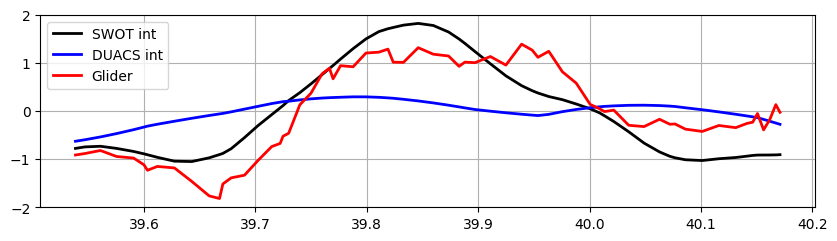

In [43]:
fig = plt.figure(figsize=(10, 2.5))

plt.plot(Lat,ssh_swot_int_an*100,c='k', label = 'SWOT int', linewidth=2)
plt.plot(Lat,np.squeeze(ssh_duacs_int_an)*100,c='b', label = 'DUACS int', linewidth=2)

plt.plot(Lat, (dh_an_glider)*100, c='red',label='Glider', linewidth=2)

plt.legend(loc='upper left')
plt.ylim(-2,2)
plt.grid(True)
#plt.savefig('/home/everger/Onedrive/SWOT/spatiotemporal_int_glider9_section4.png',dpi=1200)

In [44]:
# find lat of min dh
min_dh = np.nanmin(ssh_swot_int_an)
min_lat = Lat[np.where(ssh_swot_int_an == min_dh)[0][0]]
min_lon = Lon[np.where(ssh_swot_int_an == min_dh)[0][0]]
min_lat, min_lon

(39.64282241081126, 1.6617149913855156)

In [45]:
max_dh = np.nanmax(ssh_swot_int_an)
max_lat = Lat[np.where(ssh_swot_int_an == max_dh)[0][0]]
max_lon = Lon[np.where(ssh_swot_int_an == max_dh)[0][0]]
max_lat, max_lon

(39.846136545379494, 1.5725070837866724)

In [46]:
# distance between min and max lat
dist = gsw.distance([min_lon,max_lon],[min_lat,max_lat])
dist

array([23859.4156527])

In [47]:
np.nanmean(ssh_swot_int_an)

-2.6283689029951623e-19

In [48]:
np.nanmean(ssh_duacs_int_an)

-6.30808536718839e-19

In [49]:
np.nanmean(dh_an_glider)

3.285461128743953e-19

In [50]:
# compute rmsd
rmsd_duacs = np.sqrt(np.nanmean((ssh_duacs_int_an-dh_an_glider)**2))
rmsd_duacs

0.008221305426698043

In [51]:
rmsd_swot = np.sqrt(np.nanmean((ssh_swot_int_an-dh_an_glider)**2))
rmsd_swot

0.005514923387245892

## potential density section

In [52]:
# compute the potential density of the glider
# dens = mat['sp09']['sigma_dh'][0,0]   # el filtrat
# depth = mat['sp09']['depth_dh'][0,0]
# lat = mat['sp09']['lat_dh'][0,0][0]

In [53]:
# dir_file = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/dynamic_height/gliders/'
dir_file = '/home/everger/ONEDRIVE/SWOT/dynamic_height/gliders/'
file = 'dep0007_sdeep09_scb-sldeep009_L2_2023-04-25_data_dt.nc'

In [54]:
# open the file
ds = xr.open_dataset(dir_file + file)

In [55]:
# limit the data to the time of the glider transect
ds = ds.sel(time=slice(start_datetime, end_datetime))
ds

<xarray.Dataset>
Dimensions:               (time: 66, depth: 955)
Coordinates:
  * depth                 (depth) float64 0.0 1.0 2.0 3.0 ... 952.0 953.0 954.0
    latitude              (time) float64 ...
    longitude             (time) float64 ...
  * time                  (time) datetime64[ns] 2023-05-03T15:39:23.802705408...
Data variables: (12/13)
    backscatter_700       (time, depth) float64 ...
    cdom                  (time, depth) float64 ...
    chlorophyll           (time, depth) float64 ...
    conductivity          (time, depth) float64 ...
    density               (time, depth) float64 ...
    oxygen_concentration  (time, depth) float64 ...
    ...                    ...
    par_radiation         (time, depth) float64 ...
    pressure              (time, depth) float64 ...
    profile_index         (time) float64 ...
    salinity              (time, depth) float64 ...
    temperature           (time, depth) float64 ...
    temperature_par       (time, depth) float64 ...
Attributes: (12/46)
    abstract:                      FaSt-SWOT consists of two multi-platform e...
    acknowledgement:               Ministerio de Economía y Competitividad (h...
    author:                        SOCIB Glider facility
    author_email:                  glider@socib.es
    cdm_data_type:                 Trajectory
    citation:                      Ministerio de Economía y Competitividad (h...
    ...                            ...
    standard_name_vocabulary:      http://cf-pcmdi.llnl.gov/documents/cf-stan...
    summary:                       FaSt-SWOT consists of two multi-platform e...
    time_coverage_end:             2023-05-10T07:25:02+00:00
    time_coverage_start:           2023-04-25T23:31:49+00:00
    title:                         Glider deployment delayed time gridded data
    transmission_system:           IRIDIUM

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the colors
colors = [
    (0.87, 0.63, 0.87),  # plum
    (0.56, 0.0, 1.0),    # violet
    (0.85, 0.75, 0.85),  # thistle
    (0.25, 0.41, 0.88),  # royalblue
    (0.53, 0.81, 0.92),  # skyblue
    (0.0, 1.0, 1.0),     # cyan
    (0.42, 0.56, 0.14),  # olivedrab
    (0.2, 0.8, 0.2),     # limegreen
    (0.6, 0.8, 0.2),     # yellowgreen
    (1.0, 1.0, 0.0),     # yellow
    (1.0, 0.65, 0.0),    # orange
    (1.0, 0.55, 0.0),    # darkorange
    (1.0, 0.0, 0.0),     # red
    (0.86, 0.08, 0.24),  # crimson
    (1.0, 0.63, 0.48)    # lightsalmon
]

# Create the colormap
cmap_name = 'custom_violet_to_lightsalmon'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

In [57]:
ds

<xarray.Dataset>
Dimensions:               (time: 66, depth: 955)
Coordinates:
  * depth                 (depth) float64 0.0 1.0 2.0 3.0 ... 952.0 953.0 954.0
    latitude              (time) float64 ...
    longitude             (time) float64 ...
  * time                  (time) datetime64[ns] 2023-05-03T15:39:23.802705408...
Data variables: (12/13)
    backscatter_700       (time, depth) float64 ...
    cdom                  (time, depth) float64 ...
    chlorophyll           (time, depth) float64 ...
    conductivity          (time, depth) float64 ...
    density               (time, depth) float64 ...
    oxygen_concentration  (time, depth) float64 ...
    ...                    ...
    par_radiation         (time, depth) float64 ...
    pressure              (time, depth) float64 ...
    profile_index         (time) float64 ...
    salinity              (time, depth) float64 ...
    temperature           (time, depth) float64 ...
    temperature_par       (time, depth) float64 ...
Attributes: (12/46)
    abstract:                      FaSt-SWOT consists of two multi-platform e...
    acknowledgement:               Ministerio de Economía y Competitividad (h...
    author:                        SOCIB Glider facility
    author_email:                  glider@socib.es
    cdm_data_type:                 Trajectory
    citation:                      Ministerio de Economía y Competitividad (h...
    ...                            ...
    standard_name_vocabulary:      http://cf-pcmdi.llnl.gov/documents/cf-stan...
    summary:                       FaSt-SWOT consists of two multi-platform e...
    time_coverage_end:             2023-05-10T07:25:02+00:00
    time_coverage_start:           2023-04-25T23:31:49+00:00
    title:                         Glider deployment delayed time gridded data
    transmission_system:           IRIDIUM

In [58]:
SA = gsw.conversions.SA_from_SP(ds.salinity, ds.pressure, ds.longitude, ds.latitude)
CT = gsw.conversions.CT_from_t(SA, ds.temperature, ds.pressure)
pot_dens_an = gsw.density.sigma0(SA, CT) 
# Calculates potential density anomaly with reference pressure of 0 dbar, this being this particular potential density minus 1000 kg/m^3.

In [59]:
# meshgrid the lat and depth
lat, depth = np.meshgrid(ds.latitude.values, ds.depth.values)
lat.shape

(955, 66)

/tmp/ipykernel_224872/531620591.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


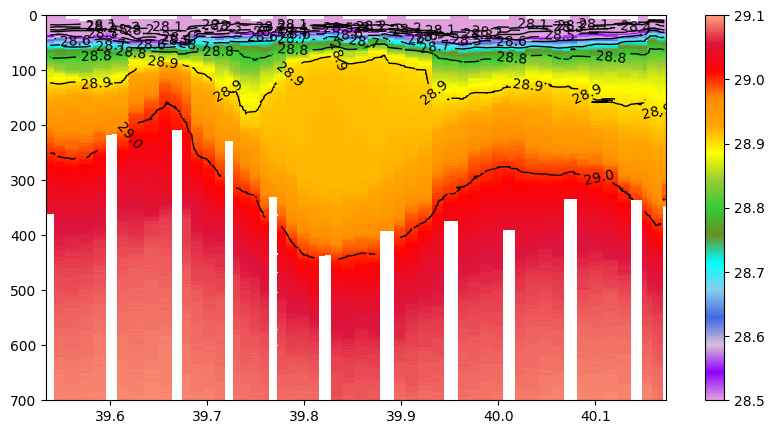

In [60]:
plt.figure(figsize=(10,5))

plt.pcolor(lat, depth, pot_dens_an.values.T,cmap=cm,vmin=28.5, vmax= 29.1,shading='auto')
plt.ylim(0,700)

plt.colorbar()

# plt the ispycnals
levels = np.arange(28.1, 29.1, 0.1)
CS = plt.contour(lat, depth, pot_dens_an.values.T, levels, colors='k', linewidths=1)

# label the isopycnals once each
plt.clabel(CS, inline=1, fontsize=10, colors='k', manual=False)

#invert y axis
plt.gca().invert_yaxis()


In [61]:
# find which density we have at 80m depth
pot_dens_80 = np.squeeze(pot_dens_an.sel(depth=80, method='nearest').values)
np.nanmean(pot_dens_80)

28.835656787615967

## TS DIAGRAM   

In [62]:
# Flatten the variables
temperature_flat = CT.values.flatten()
salinity_flat = SA.values.flatten()
depth_flat = ds.depth.values.flatten()

In [63]:
# Define the min / max values for plotting isopycnals
t_min = np.nanmin(CT) -0.2
t_max = np.nanmax(CT) -0.2
s_min = np.nanmin(SA) -0.25
s_max = np.nanmax(SA) -0.25

In [64]:
# Calculate how many gridcells we need in the x and y dimensions
xdim = np.ceil(s_max - s_min)/0.1
ydim = np.ceil(t_max-t_min)
dens = np.zeros((int(ydim),int(xdim)))

In [65]:
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(0,int(ydim),int(ydim))+t_min
si = np.linspace(1,int(xdim),int(xdim))*0.1+s_min

In [66]:
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        dens[j,i]=gsw.rho(si[i],ti[j],0)

# Subtract 1000 to convert to sigma-t
dens = dens - 1000

In [67]:
import cmocean

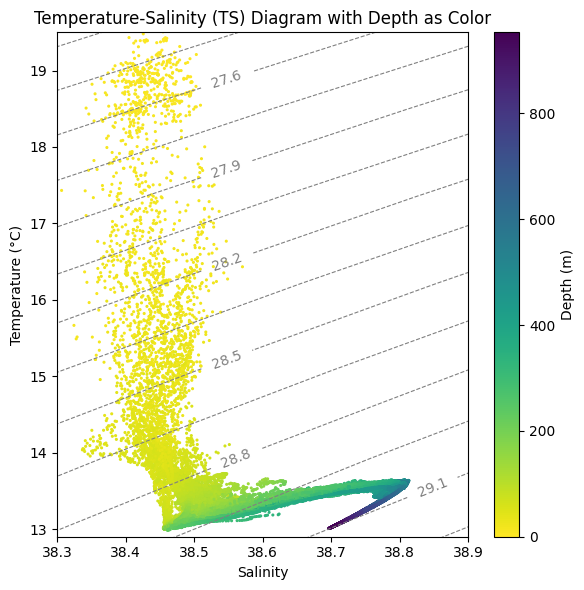

In [68]:
# Create the TS diagram
plt.figure(figsize=(6, 6))

sc = plt.scatter(salinity_flat, temperature_flat, c=depth.T, cmap= 'viridis_r', s=1.5) # cmocean.cm.dense
CS = plt.contour(si,ti,dens, levels=20, linestyles='dashed', linewidths=0.8, colors='gray')

# Select every second level to label
levels_to_label = CS.levels[::2]

# Add labels to every second contour level
plt.clabel(CS, levels=levels_to_label, inline=1, fontsize=10, colors='gray')

plt.colorbar(sc, label='Depth (m)')
plt.xlabel('Salinity')
plt.ylabel('Temperature (°C)')
plt.title('Temperature-Salinity (TS) Diagram with Depth as Color')
# set limits
plt.xlim(38.3, 38.9)
plt.ylim(12.9, 19.5)
plt.tight_layout()
plt.show()

## glider tansect

In [69]:
lonminz, lonmaxz, latminz, latmaxz = 1.4, 1.8,39.5,40.2

/home/everger/anaconda3/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


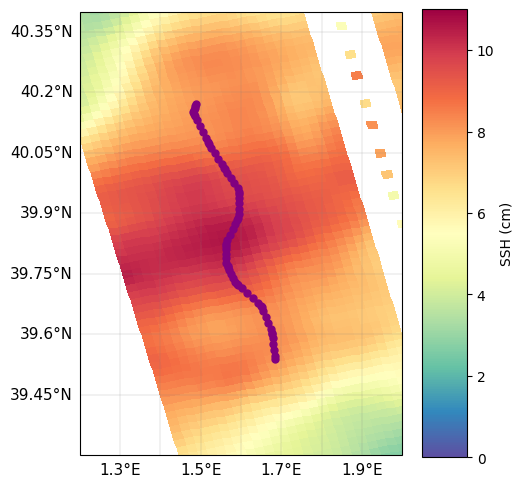

In [70]:
fig = plt.figure(figsize=(5,5))

gs  = gridspec.GridSpec(1, 1)
ax  = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())

# domain extent
ax.set_extent([lonminz-0.2, lonmaxz+0.2, latminz-0.2, latmaxz+0.2], ccrs.PlateCarree())

sc=plt.scatter(Lon,Lat,100,marker='.',c='purple',label = 'glider 01',zorder=10)

plot = plt.pcolormesh(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.ssha_noiseless*100, 
                               transform=ccrs.PlateCarree(), vmin=0,vmax=11, cmap='Spectral_r')

# add colorbar
cbar = plt.colorbar(plot, orientation='vertical', label='SSH (cm)', pad=0.05, aspect=10)

# Grid and ticks
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='-',zorder=2)

gl.top_labels = False
gl.right_labels = False

gl.xlabel_style = {'size': 11}#, 'color': 'gray'}
gl.ylabel_style = {'size': 11}#, 'color': 'gray'}

plt.tight_layout()

## ALL TOGETHER

In [71]:
# compute rmsd
rmsd_duacs = np.sqrt(np.nanmean((ssh_duacs_int_an-(dh_an_glider))**2))
rmsd_duacs

0.008221305426698043

In [72]:
# compute rmsd swot
rmsd_swot = np.sqrt(np.nanmean((ssh_swot_int_an-(dh_an_glider))**2))
rmsd_swot

0.005514923387245892

In [73]:
rmsd_swot/rmsd_duacs * 100

67.0808722096203

## DEF


In [74]:
# OPEN SWOT FILE
path_sw = '/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/v01/expert/'
# path_sw = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/SWOT_data_L3/v01/expert/'

files_sw = np.sort(glob.glob(path_sw+'*016_*.nc'))
files_sw = files_sw[19] # 28/04 a 2/05
files_sw

'/home/everger/ONEDRIVE/SWOT/SWOT_data_L3/v01/expert/SWOT_L3_LR_SSH_Expert_511_016_20230505T050152_20230505T055256_v1.0.nc'

In [75]:
ds_SWOT = xr.open_dataset(files_sw)

# cut the data to the region of interest data_array = data_array.where((data_array['longitude'].compute() < lon_max) & (data_array['longitude'].compute() > lon_min) & 
# (data_array['latitude'].compute() < lat_max) & (data_array['latitude'].compute() > lat_min), drop=True)

ds_SWOT = ds_SWOT.where((ds_SWOT['longitude'] < 1.9) & (ds_SWOT['longitude'] > 1))
ds_SWOT = ds_SWOT.where((ds_SWOT['latitude'] < 40.5) & (ds_SWOT['latitude'] > 39.3))
ds_SWOT

<xarray.Dataset>
Dimensions:               (num_lines: 9860, num_pixels: 69, num_nadir: 1344)
Coordinates:
    latitude              (num_lines, num_pixels) float64 78.27 78.25 ... -78.27
    longitude             (num_lines, num_pixels) float64 286.1 286.1 ... 92.99
Dimensions without coordinates: num_lines, num_pixels, num_nadir
Data variables: (12/18)
    time                  (num_lines, num_pixels) datetime64[ns] NaT NaT ... NaT
    mdt                   (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha                  (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_noiseless        (num_lines, num_pixels) float64 nan nan ... nan nan
    ssha_unedited         (num_lines, num_pixels) float64 nan nan ... nan nan
    quality_flag          (num_lines, num_pixels) float32 nan nan ... nan nan
    ...                    ...
    ugosa                 (num_lines, num_pixels) float64 nan nan ... nan nan
    vgosa                 (num_lines, num_pixels) float64 nan nan ... nan nan
    sigma0                (num_lines, num_pixels) float64 nan nan ... nan nan
    cross_track_distance  (num_pixels, num_lines) float64 nan nan ... nan nan
    i_num_line            (num_nadir, num_lines, num_pixels) float32 nan ... nan
    i_num_pixel           (num_nadir, num_lines, num_pixels) float32 nan ... nan
Attributes: (12/42)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea Surface Height measured by Altimetry
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_min:              -78.272132
    geospatial_lat_max:              78.272321
    geospatial_lon_min:              6.5e-05
    geospatial_lon_max:              359.999908
    data_used:                       SWOT KaRIn L2_LR_SSH PGC0 (NASA/CNES). D...
    doi:                             https://doi.org/10.24400/527896/A01-2023...

In [76]:
adt_swot = (ds_SWOT.ssha_noiseless+ds_SWOT.mdt) - np.nanmean(ds_SWOT.ssha_noiseless+ds_SWOT.mdt)
adt_swot

<xarray.DataArray (num_lines: 9860, num_pixels: 69)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (num_lines, num_pixels) float64 78.27 78.25 ... -78.25 -78.27
    longitude  (num_lines, num_pixels) float64 286.1 286.1 286.1 ... 92.99 92.99
Dimensions without coordinates: num_lines, num_pixels

/tmp/ipykernel_224872/1142531891.py:30: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(sc2, ax=ax2, label='Potential Density anomaly (kg/m³)', orientation='horizontal', aspect=50, pad = 0.02, anchor=(0.5, -1))
/home/everger/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/everger/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


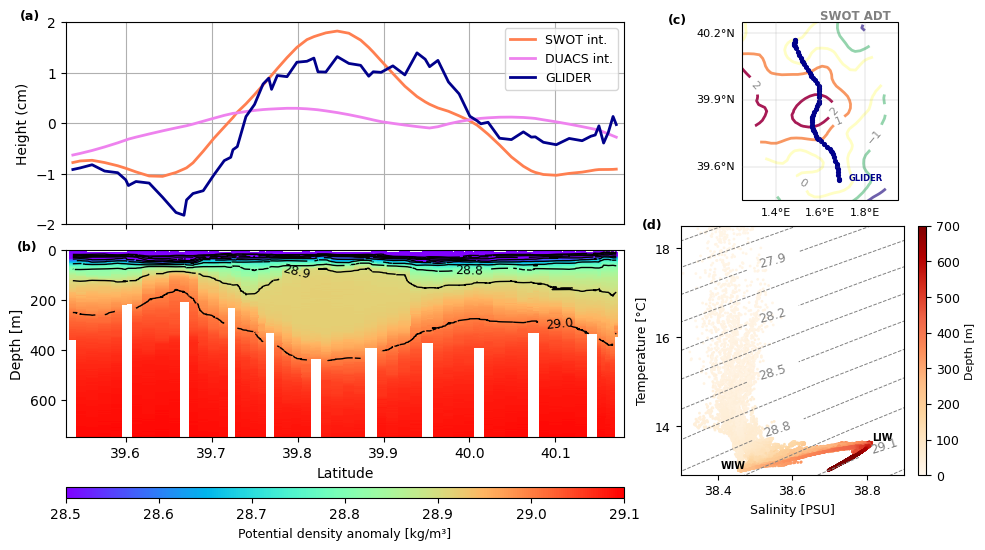

In [77]:
# Create the figure and main gridspec layout with adjusted width ratios
fig = plt.figure(figsize=(10, 10))
main_gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])  # Adjusting the width ratio (Left larger, Right smaller)

# Create a nested gridspec within the left column for ax1 and ax2
left_gs = main_gs[0].subgridspec(2, 1, height_ratios=[1.8, 2])  # ax2 is taller than ax1
right_gs = main_gs[1].subgridspec(2, 1, height_ratios=[1, 1.4])

###################################################################################
# Create the first subplot (top left, narrower)
ax1 = fig.add_subplot(left_gs[0])
ax1.plot(Lat, ssh_swot_int_an*100, c='coral', label='SWOT int.', linewidth=2)
ax1.plot(Lat, ssh_duacs_int_an*100, c='violet', label='DUACS int.', linewidth=2)
ax1.plot(Lat, (dh_an_glider)*100, c='darkblue', label='GLIDER', linewidth=2)
ax1.set_ylabel('Height (cm)', fontsize=10)
ax1.set_ylim(-2, 2)
# reduce number of ticks
ax1.locator_params(axis='y', nbins=5)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.set_xlim(39.53, 40.18)
ax1.legend(fontsize=9)  

# ###################################################################################
# Create the second subplot (bottom left, wider)
ax2 = fig.add_subplot(left_gs[1])
sc2 = ax2.pcolor(lat, depth, pot_dens_an.T, cmap='rainbow', vmin=28.5, vmax=29.1, shading='auto')
ax2.set_xlabel('Latitude', fontsize=10)
ax2.set_ylabel('Depth [m]', fontsize=10)
cbar = fig.colorbar(sc2, ax=ax2, label='Potential Density anomaly (kg/m³)', orientation='horizontal', aspect=50, pad = 0.02, anchor=(0.5, -1))
cbar.set_label('Potential density anomaly [kg/m³]', fontsize=9)
ax2.set_ylim(0, 750)
# reduce number of ticks
ax2.locator_params(axis='y', nbins=7)

# Plot the isopycnals
levels = np.arange(28.1, 29.2, 0.1)
CS = ax2.contour(lat, depth, pot_dens_an.T, levels, colors='k', linewidths=1)
manual_locations = [(39.8, 100), (40.0, 70), (40.1, 400)]
ax2.clabel(CS, inline=1, fontsize=9, colors='k', manual=manual_locations)
ax2.set_xlim(39.53, 40.18)
ax2.invert_yaxis()

# ###################################################################################
# Create the third subplot (right, spanning both rows)
ax3 = fig.add_subplot(right_gs[1])  # Share the y-axis with ax2

sc3 = ax3.scatter(salinity_flat, temperature_flat, c=depth.T, cmap='OrRd', s=1, vmin=0, vmax=700)

isopic = ax3.contour(si, ti, dens, levels=20, linestyles='dashed', linewidths=0.7, colors='gray')

# Select every second level to label
levels_to_label = isopic.levels[::2]

# Add labels to every second contour level
ax3.clabel(isopic, levels=levels_to_label, inline=1, fontsize=9, colors='gray')
ax3.set_xlim(38.3, 38.9)
ax3.set_ylim(12.9, 18.5)
# change ticks size
ax3.tick_params(axis='both', which='major', labelsize=9)

# reduce number of y ticks
ax3.locator_params(axis='y', nbins=4)

ax3.set_xlabel('Salinity [PSU]', fontsize=9)
ax3.set_ylabel('Temperature [°C]', fontsize=9)
cbar3 = fig.colorbar(sc3, ax=ax3, label='Depth (m)', aspect=30)
cbar3.ax.tick_params(labelsize=9)

# change size of colorbar title
cbar3.set_label('Depth [m]', fontsize=8)

# add text
ax3.text(0.95, 0.17, 'LIW', color= 'black', transform=ax3.transAxes, fontweight= 'bold',fontsize=7, va='top', ha='right')
ax3.text(0.29, 0.06, 'WIW', color= 'black', transform=ax3.transAxes, fontweight= 'bold',fontsize=7, va='top', ha='right')

# # Add inset map
ax4 = fig.add_subplot(right_gs[0], projection=ccrs.PlateCarree())
ax4.set_extent([1.25, 1.95, 39.45, 40.25], ccrs.PlateCarree())

CS=ax4.contour(ds_SWOT.longitude, ds_SWOT.latitude, adt_swot * 100, vmin=-2, vmax=2,
                 cmap='Spectral_r', linewidths = 2, alpha = 0.9, levels = 7, transform=ccrs.PlateCarree())

ax4.scatter(Lon, Lat, 30, marker='.', c='darkblue', label='GLIDER',zorder=10)

ax4.clabel(CS, inline=True, fontsize=8, colors='gray')

ax4.text(0.95,1.07, 'SWOT ADT', transform= ax4.transAxes, fontsize=8.5, va='top', ha='right', color='gray', fontweight = 'bold')
ax4.text(0.9, 0.15, 'GLIDER', transform=ax4.transAxes,color= 'darkblue', fontweight = 'bold', fontsize=6, va='top', ha='right')


# Add gridlines
gl = ax4.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='-', zorder=10)

# Change gl label size
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = plt.MaxNLocator(3)
gl.xlocator = plt.MaxNLocator(4)


# # Add labels to the subplots
ax1.text(-0.045, 1.06, '(a)', transform=ax1.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
ax2.text(-0.05, 1.05, '(b)', transform=ax2.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
ax3.text(0.03, 1.85, '(c)', transform=ax3.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
ax3.text(-0.08, 1.03, '(d)', transform=ax3.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

plt.tight_layout()

# Reduce space between subplots
plt.subplots_adjust(hspace=0.12, wspace=0.135)

# plt.savefig('/home/everger/ONEDRIVE/SWOT/subplots_glider9_section4_def_v6.png',dpi=200, bbox_inches='tight',pad_inches=0.1)

/home/everger/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/everger/anaconda3/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/tmp/ipykernel_224872/392637740.py:48: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(sc2, ax=ax2, label='Potential Density anomaly (kg/m³)', orientation='horizontal', aspect=50, pad=0.01, anchor=(0, 0.15))
/tmp/ipykernel_224872/392637740.py:67: UserWarning: This figure includes Axes that are 

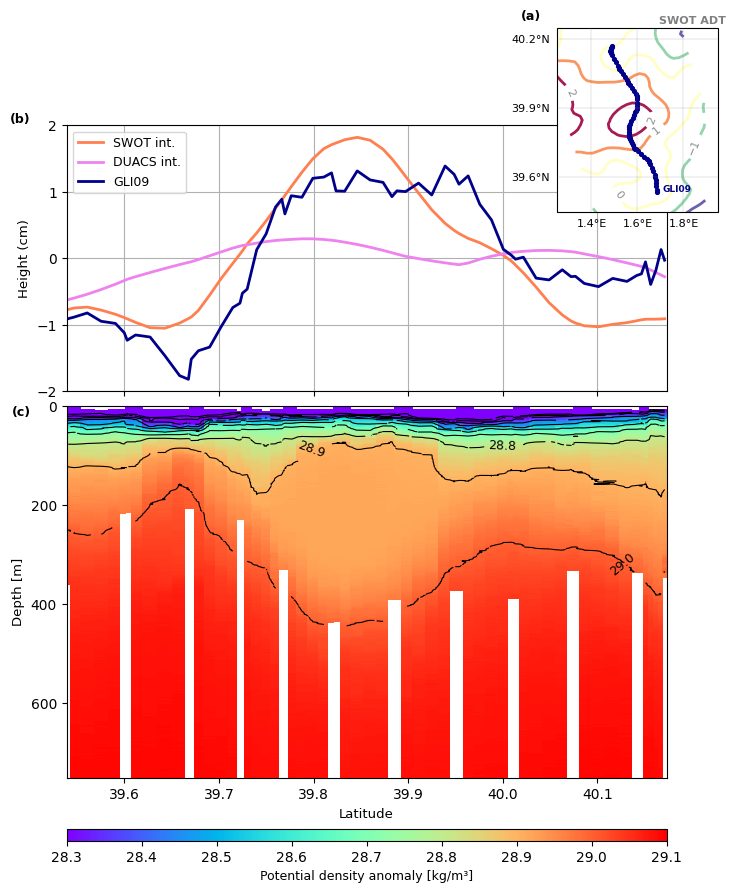

In [78]:
# Create the figure and main gridspec layout with adjusted width ratios
fig = plt.figure(figsize=(7, 8))
main_gs = fig.add_gridspec(2, 1,  height_ratios=[0.6, 1])  # Left larger, Right smaller


###################################################################################
# Create the first subplot (top left)
ax1 = fig.add_subplot(main_gs[0])
ax1.plot(Lat, ssh_swot_int_an * 100, c='coral', label='SWOT int.', linewidth=2)
ax1.plot(Lat, ssh_duacs_int_an * 100, c='violet', label='DUACS int.', linewidth=2)
ax1.plot(Lat, dh_an_glider * 100, c='darkblue', label='GLI09', linewidth=2)
ax1.set_ylabel('Height (cm)', fontsize=9.5)
ax1.set_ylim(-2, 2)
ax1.locator_params(axis='y', nbins=5)
ax1.grid(True)
ax1.set_xticklabels([])
ax1.set_xlim(39.539, 40.173)
ax1.legend(fontsize=9, loc='upper left')

# Add subplot (c) as an inset within (a)
inset_ax = fig.add_axes([0.8, 0.86, 0.23, 0.23], projection=ccrs.PlateCarree())  # [left, bottom, width, height]
inset_ax.set_extent([1.25, 1.95, 39.45, 40.25], ccrs.PlateCarree())

CS = inset_ax.contour(ds_SWOT.longitude, ds_SWOT.latitude, adt_swot * 100, vmin=-2, vmax=2,
                 cmap='Spectral_r', linewidths=2, alpha=0.9, levels=7, transform=ccrs.PlateCarree())

inset_ax.scatter(Lon, Lat, 30, marker='.', c='darkblue', label='GLI09', zorder=10)
inset_ax.clabel(CS, inline=True, fontsize=8, colors='gray')

inset_ax.text(-0.14, 0.45, 'SWOT ADT', transform=ax4.transAxes, fontsize=8, va='top', ha='right', color='gray', fontweight='bold')
inset_ax.text(-0.36, -0.5, 'GLI09', transform=ax4.transAxes, color='darkblue', fontweight='bold', fontsize=6.5, va='top', ha='right')

# Add gridlines
gl = inset_ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='-', zorder=10)
gl.xlabel_style = {'size': 8, 'color': 'black'}
gl.ylabel_style = {'size': 8, 'color': 'black'}
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = plt.MaxNLocator(3)
gl.xlocator = plt.MaxNLocator(4)

###################################################################################
# Create the second subplot (bottom left)
ax2 = fig.add_subplot(main_gs[1])
sc2 = ax2.pcolor(lat, depth, pot_dens_an.T, cmap='rainbow', vmin=28.3, vmax=29.1) #vmin=28.5, vmax=29.1,
ax2.set_xlabel('Latitude', fontsize=9.5)
ax2.set_ylabel('Depth [m]', fontsize=9.5)
cbar = fig.colorbar(sc2, ax=ax2, label='Potential Density anomaly (kg/m³)', orientation='horizontal', aspect=50, pad=0.01, anchor=(0, 0.15))
cbar.set_label('Potential density anomaly [kg/m³]', fontsize=9)
ax2.set_ylim(0, 750)
ax2.locator_params(axis='y', nbins=7)
levels = np.arange(28.1, 29.2, 0.1)

levels = np.arange(28.1, 29.2, 0.1)
CS = ax2.contour(lat, depth, pot_dens_an.T, levels, colors='k', linewidths=0.8)
manual_locations = [(39.8, 100), (40.0, 70), (40.1, 400)]
ax2.clabel(CS, inline=1, fontsize=9, colors='k', manual=manual_locations)
ax2.set_xlim(39.539, 40.173)
ax2.invert_yaxis()

###################################################################################
# Add a,b,c
ax1.text(-0.06, 1.05, '(b)', transform=ax1.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
ax2.text(-0.06, 1, '(c)', transform=ax2.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')
inset_ax.text(-0.1, 1.1, '(a)', transform=inset_ax.transAxes, fontsize=9, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.subplots_adjust(hspace=0.04, wspace=0.1)

# save figure
# plt.savefig('subplots_glider9_section4_def.png',dpi=200, bbox_inches='tight',pad_inches=0.1)

/tmp/ipykernel_224872/1195379111.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Salinity [PSU]')
/tmp/ipykernel_224872/1195379111.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label='Temperature [°C]')


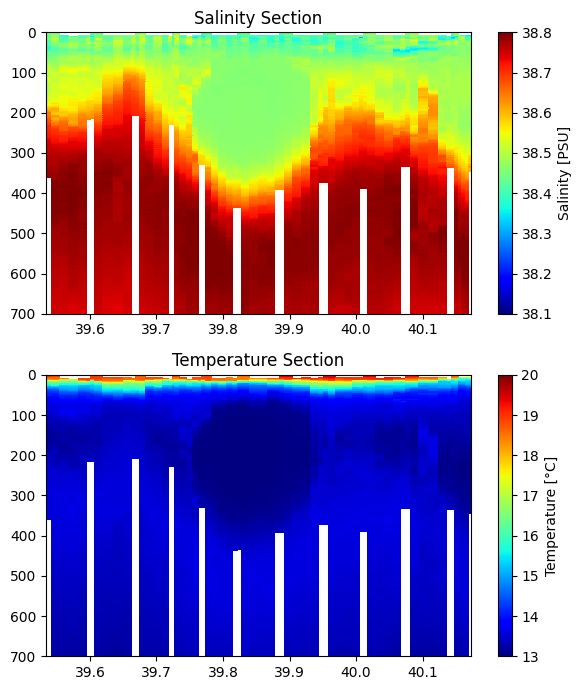

In [79]:
# subplot of salinity and temperature sections
plt.figure(figsize=(6, 7))
plt.subplot(2, 1, 1)
plt.pcolor(Lat, depth, SA.values.T, cmap='jet', vmin=38.1, vmax =38.8) #cmocean.cm.haline

plt.clabel(CS, inline=1, fontsize=10, colors='k', manual=False)

plt.colorbar(label='Salinity [PSU]')
plt.title('Salinity Section')
plt.ylim(0, 700)
plt.gca().invert_yaxis()

plt.subplot(2, 1, 2)
plt.pcolor(Lat, depth, CT.values.T,  cmap='jet', vmin=13, vmax =20) #cmap=cmocean.cm.thermal
plt.colorbar(label='Temperature [°C]')
plt.title('Temperature Section')
plt.ylim(0, 700)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()